In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from collections import Counter

from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

TF-iDF vectorizer wrapper class for end-to-end vectorization:

In [2]:
class Vectorizer:
    def __init__(self, k=10000):
        self.vectorizer = TfidfVectorizer()
        self.vocab = None
        self.k = k

    def fit(self, texts):
        self.k = min(self.k, len(set(" ".join(texts).split())))

        self.vectorizer.fit(texts)
        counts = Counter(' '.join(texts).split())
        self.vocab = [key for key, val in counts.most_common(self.k)]

    def transform(self, texts):
        return self.vectorizer.transform(texts)

    def fit_transform(self, texts):
        self.fit(texts)
        return self.transform(texts)

    def get_tf_idf(self, texts):
        vectorized = self.transform(texts)
        names = self.vectorizer.get_feature_names_out()

        return self.tfidf_in_vocab(vectorized, names)

    def tfidf_in_vocab(self, vectorized, names):
        df = pd.DataFrame(vectorized.todense(), columns=names)
        sent_matr = df.drop(list(df.columns.difference(self.vocab)), axis=1)
        res_matr = np.zeros((sent_matr.shape[0], len(self.vocab)))
        for i, token in enumerate(self.vocab):
            if token in sent_matr.columns:
                res_matr[:, i] = sent_matr[token].to_numpy()
        return res_matr

A little function to visualize training results:

In [3]:
def visualize_and_save_results(
    model, model_name, X_train, X_test, y_train, y_test, out_dict
):
    for data_name, X, y, model in [
        ("train", X_train, y_train, model),
        ("test", X_test, y_test, model),
    ]:
        proba = model.predict_proba(X)[:, 1]

        auc = roc_auc_score(y, proba)

        out_dict[f"{model_name}_{data_name}"] = auc
        plt.plot(*roc_curve(y, proba)[:2], label="{} AUC={:.4f}".format(data_name, auc))

    plt.plot(
        [0, 1],
        [0, 1],
        "--",
        color="black",
    )
    plt.legend(fontsize="large")
    plt.title(model_name)
    plt.grid()
    return out_dict

NB classifier with posterior Multinomial distribution to classify TF-iDF vectors:

In [4]:
from sklearn.naive_bayes import MultinomialNB

clf_nb_tfidf = MultinomialNB()

In [5]:
# A litte preprocess function for the texts
preprocess = lambda text: ' '.join(WordPunctTokenizer().tokenize(text.lower()))

In [6]:
df_with_texts_and_labels = pd.read_csv('texts.csv')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_with_texts_and_labels['text'],
                                                    df_with_texts_and_labels['substantive'],
                                                    test_size = 0.2, random_state=42)

X_train = X_train.apply(preprocess).tolist()
X_test = X_test.apply(preprocess).tolist()

all_texts = df_with_texts_and_labels['text'].apply(preprocess).tolist()

In [8]:
vectorizer = Vectorizer()
vectorizer.fit(all_texts)

X_train_tfidf = vectorizer.get_tf_idf(X_train)
X_test_tfidf = vectorizer.get_tf_idf(X_test)

In [9]:
clf_nb_tfidf.fit(X_train_tfidf, y_train)

train_preds = clf_nb_tfidf.predict(X_train_tfidf)
test_preds = clf_nb_tfidf.predict(X_test_tfidf)

In [10]:
print(accuracy_score(train_preds, y_train.to_numpy()))
print(accuracy_score(test_preds, y_test.to_numpy()))

1.0
0.9285714285714286


{'NB_tfidf_train': np.float64(1.0), 'NB_tfidf_test': np.float64(1.0)}

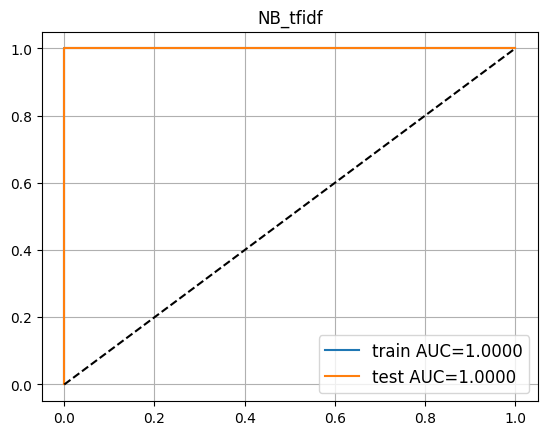

In [11]:
out_dict = {}
visualize_and_save_results(
    clf_nb_tfidf, "NB_tfidf", X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict
)

Save the model and vectorizer:

In [12]:
with open('../model.pickle', 'wb') as f:
    pickle.dump(clf_nb_tfidf, f)

with open('../vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)